# CMIP6-based Multi-model Hydroclimate Projection over the Conterminous US


## Virtualizarr

Create a virtual reference dataset that maps Zarr arrays to remote NetCDF byte ranges

THis is a good candidate dataset for https://github.com/zarr-developers/VirtualiZarr

In [1]:
# Use Virtualizarr to construct a virtual dataset for 1 year
import xarray as xr
from virtualizarr import open_virtual_dataset
import fsspec
%matplotlib inline

In [2]:
def pull_from_globus(met_data = 'DaymetV4', hydro_model = 'VIC4', variable = 'prcp', year = '1980'):
    globus_root = 'https://g-e320e6.63720f.75bc.data.globus.org/gen101/world-shared/doi-data/OLCF/202402/10.13139_OLCF_2311812/'
    file_path = f'{met_data}/{variable}/{met_data}_{hydro_model}_{variable}_{year}.nc'
    url = f'{globus_root}/{file_path}'
    local_path = fsspec.open_local(f"filecache::{url}", filecache={'cache_storage': '/tmp/fsspec_cache'}, same_names=True)
    
    return local_path

path1 = pull_from_globus(year='1980')
path2 = pull_from_globus(year='1981')

In [3]:
print(path1, path2)

/tmp/fsspec_cache/DaymetV4_VIC4_prcp_1980.nc /tmp/fsspec_cache/DaymetV4_VIC4_prcp_1981.nc


In [4]:
# NOTE: https://virtualizarr.readthedocs.io/en/latest/usage.html#cf-encoded-time-variables
vds1 = open_virtual_dataset(path1, indexes={}, 
                            loadable_variables=['time'], 
                            decode_times=True,
)
vds1

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 366, lat: 697, lon: 1405)
Coordinates:
    lat      (lat) float64 6kB ManifestArray<shape=(697,), dtype=float64, chu...
    lon      (lon) float64 11kB ManifestArray<shape=(1405,), dtype=float64, c...
  * time     (time) datetime64[ns] 3kB 1980-01-01T12:00:00 ... 1980-12-31T12:...
Data variables:
    prcp     (time, lat, lon) float32 1GB ManifestArray<shape=(366, 697, 1405...
Attributes:
    Conventions:              CF-1.8
    Forcing:                  DaymetV4, aggregated to 4km ORNL CONUS-VIC4 grids
    VIC_parameters:           ORNL CONUS-VIC4 v20200704D
    computational_resources:  Oak Ridge Leadership Computing Facility at the ...
    contact:                  Shih-Chieh Kao (kaos@ornl.gov)
    creation_date:            19-Jul-2023 14:35:47
    domain:                   Conterminous US (CONUS)
    experiment:               DaymetV4_VIC5
    institution:              Oak Ridge National Laboratory, Oak Ridge, TN, USA
    title:                    SECURE Water Act 9505V3 Assessment

In [5]:
# NOTE: https://virtualizarr.readthedocs.io/en/latest/usage.html#cf-encoded-time-variables
vds2 = open_virtual_dataset(path2, indexes={}, 
                            loadable_variables=['time'], 
                            decode_times=True,
                            #cftime_variables=['time'],
)
vds2

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 365, lat: 697, lon: 1405)
Coordinates:
    lat      (lat) float64 6kB ManifestArray<shape=(697,), dtype=float64, chu...
    lon      (lon) float64 11kB ManifestArray<shape=(1405,), dtype=float64, c...
  * time     (time) datetime64[ns] 3kB 1981-01-01T12:00:00 ... 1981-12-31T12:...
Data variables:
    prcp     (time, lat, lon) float32 1GB ManifestArray<shape=(365, 697, 1405...
Attributes:
    Conventions:              CF-1.8
    Forcing:                  DaymetV4, aggregated to 4km ORNL CONUS-VIC4 grids
    VIC_parameters:           ORNL CONUS-VIC4 v20200704D
    computational_resources:  Oak Ridge Leadership Computing Facility at the ...
    contact:                  Shih-Chieh Kao (kaos@ornl.gov)
    creation_date:            24-Jan-2023 13:58:49
    domain:                   Conterminous US (CONUS)
    experiment:               DaymetV4_VIC5
    institution:              Oak Ridge National Laboratory, Oak Ridge, TN, USA
    title:                    SECURE Water Act 9505V3 Assessment

In [6]:
combined_vds = xr.concat([vds1, vds2], dim='time', coords='minimal', compat='override')
combined_vds

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 731, lat: 697, lon: 1405)
Coordinates:
    lat      (lat) float64 6kB ManifestArray<shape=(697,), dtype=float64, chu...
    lon      (lon) float64 11kB ManifestArray<shape=(1405,), dtype=float64, c...
  * time     (time) datetime64[ns] 6kB 1980-01-01T12:00:00 ... 1981-12-31T12:...
Data variables:
    prcp     (time, lat, lon) float32 3GB ManifestArray<shape=(731, 697, 1405...
Attributes:
    Conventions:              CF-1.8
    Forcing:                  DaymetV4, aggregated to 4km ORNL CONUS-VIC4 grids
    VIC_parameters:           ORNL CONUS-VIC4 v20200704D
    computational_resources:  Oak Ridge Leadership Computing Facility at the ...
    contact:                  Shih-Chieh Kao (kaos@ornl.gov)
    creation_date:            19-Jul-2023 14:35:47
    domain:                   Conterminous US (CONUS)
    experiment:               DaymetV4_VIC5
    institution:              Oak Ridge National Laboratory, Oak Ridge, TN, USA
    title:                    SECURE Water Act 9505V3 Assessment

In [7]:
combined_vds.virtualize.to_kerchunk('combined.json', format='json')

In [8]:
# NOTE: cf-time handling improved with recent changes to virtualizarr so install from main

# OverflowError: time values outside range of 64 bit signed integers #nothin
# OutOfBoundsTimedelta: Cannot cast 9.969209968386869e+36 from D to 'ns' without overflow. #use_cftime=False
#combined_ds = xr.open_dataset('combined.json', engine="kerchunk", use_cftime=False) # integers time since 1980 :)
# integers time since 1980 :)
#combined_ds = xr.open_dataset('combined.json', engine="kerchunk", decode_times=False) 

# This will use Zarr behind the scenes to read the metadata. data arrays are retrieved directly from .nc files
ds = xr.open_dataset('combined.json', engine="kerchunk")
ds

<xarray.Dataset> Size: 3GB
Dimensions:  (lat: 697, lon: 1405, time: 731)
Coordinates:
  * lat      (lat) float64 6kB 24.0 24.04 24.08 24.12 ... 52.87 52.92 52.96 53.0
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
  * time     (time) datetime64[ns] 6kB 1980-01-01T12:00:00 ... 1981-12-31T12:...
Data variables:
    prcp     (time, lat, lon) float32 3GB ...
Attributes:
    Conventions:              CF-1.8
    Forcing:                  DaymetV4, aggregated to 4km ORNL CONUS-VIC4 grids
    VIC_parameters:           ORNL CONUS-VIC4 v20200704D
    computational_resources:  Oak Ridge Leadership Computing Facility at the ...
    contact:                  Shih-Chieh Kao (kaos@ornl.gov)
    creation_date:            19-Jul-2023 14:35:47
    domain:                   Conterminous US (CONUS)
    experiment:               DaymetV4_VIC5
    institution:              Oak Ridge National Laboratory, Oak Ridge, TN, USA
    title:                    SECURE Water Act 9505V3 Assessment

In [9]:
combined_vds.virtualize.to_kerchunk('combined.parq', format='parquet')
ds_parquet = xr.open_dataset('combined.parq', engine="kerchunk")
ds_parquet

<xarray.Dataset> Size: 3GB
Dimensions:  (lat: 697, lon: 1405, time: 731)
Coordinates:
  * lat      (lat) float64 6kB 24.0 24.04 24.08 24.12 ... 52.87 52.92 52.96 53.0
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
  * time     (time) datetime64[ns] 6kB 1980-01-01T12:00:00 ... 1981-12-31T12:...
Data variables:
    prcp     (time, lat, lon) float32 3GB ...
Attributes:
    Conventions:              CF-1.8
    Forcing:                  DaymetV4, aggregated to 4km ORNL CONUS-VIC4 grids
    VIC_parameters:           ORNL CONUS-VIC4 v20200704D
    computational_resources:  Oak Ridge Leadership Computing Facility at the ...
    contact:                  Shih-Chieh Kao (kaos@ornl.gov)
    creation_date:            19-Jul-2023 14:35:47
    domain:                   Conterminous US (CONUS)
    experiment:               DaymetV4_VIC5
    institution:              Oak Ridge National Laboratory, Oak Ridge, TN, USA
    title:                    SECURE Water Act 9505V3 Assessment

In [10]:
# Convert local paths to HTTPS URLs before saving
def local_to_url(local_path: str) -> str:
    from pathlib import Path
    globus_root = 'https://g-e320e6.63720f.75bc.data.globus.org/gen101/world-shared/doi-data/OLCF/202402/10.13139_OLCF_2311812'
    filename = Path(local_path).name
    met_model, hydro_model, variable, year = filename.split('_')
    url = f'{globus_root}/{met_model}/{variable}/{filename}'

    return url

In [11]:
renamed_vds = combined_vds.virtualize.rename_paths(local_to_url)
#renamed_vds['prcp'].data.manifest.dict()

In [12]:
renamed_vds.virtualize.to_kerchunk('prcp-globus.json', format='json')

In [13]:
ds = xr.open_dataset('prcp-globus.json', engine="kerchunk")
ds

<xarray.Dataset> Size: 3GB
Dimensions:  (lat: 697, lon: 1405, time: 731)
Coordinates:
  * lat      (lat) float64 6kB 24.0 24.04 24.08 24.12 ... 52.87 52.92 52.96 53.0
  * lon      (lon) float64 11kB -125.0 -125.0 -124.9 ... -66.58 -66.54 -66.5
  * time     (time) datetime64[ns] 6kB 1980-01-01T12:00:00 ... 1981-12-31T12:...
Data variables:
    prcp     (time, lat, lon) float32 3GB ...
Attributes:
    Conventions:              CF-1.8
    Forcing:                  DaymetV4, aggregated to 4km ORNL CONUS-VIC4 grids
    VIC_parameters:           ORNL CONUS-VIC4 v20200704D
    computational_resources:  Oak Ridge Leadership Computing Facility at the ...
    contact:                  Shih-Chieh Kao (kaos@ornl.gov)
    creation_date:            19-Jul-2023 14:35:47
    domain:                   Conterminous US (CONUS)
    experiment:               DaymetV4_VIC5
    institution:              Oak Ridge National Laboratory, Oak Ridge, TN, USA
    title:                    SECURE Water Act 9505V3 Assessment

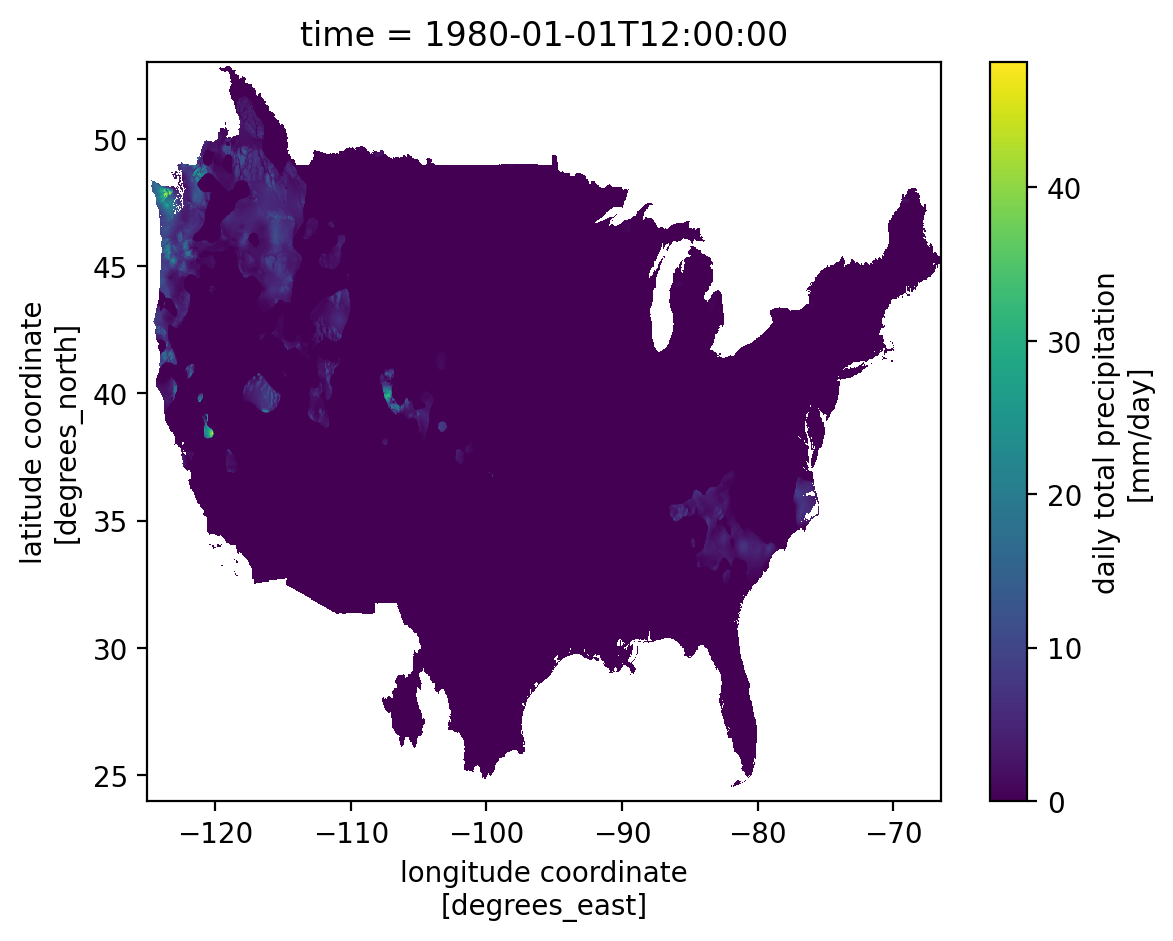

In [14]:
ds.prcp.isel(time=0).plot()